In [1]:
# Get the output of Q/K for 4k and 64K before rope and after rope
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from types import MethodType
import json
import matplotlib.pyplot as plt

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

with open("/home/azzhang/streaming-llm/output/wikitext2_prompts_llama3.json", "r", encoding="utf-8") as f:
    prompts = json.load(f)
target_length_64k = "64k"
target_length_4k = "4k"

prompt_64k = prompts[target_length_64k]
prompt_4k = prompts[target_length_4k]
inputs_64k = tokenizer(prompt_64k, return_tensors="pt").to(model.device)
inputs_4k = tokenizer(prompt_4k, return_tensors="pt").to(model.device)
seq_len_64 = inputs_64k["input_ids"].shape[1]
seq_len_4 = inputs_4k["input_ids"].shape[1]

cache_4k = {}
cache_64k = {}
rope_para_4k = {}
rope_para_64k = {}

target_layer = 10

def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
    q = self.q_proj(hidden_states)
    k = self.k_proj(hidden_states)
    v = self.v_proj(hidden_states)

    bsz, seqlen, dim = q.shape
    head_dim = self.head_dim
    
    num_heads_q = self.config.num_attention_heads
    num_heads_kv = self.config.num_key_value_heads
    
    if seqlen == seq_len_4:
        print(seq_len_4)
        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)
        
        # Q、K before rope
        cache_4k["q_raw"] = q.detach().cpu()
        cache_4k["k_raw"] = k.detach().cpu()
        
        cos, sin = position_embeddings
        
        rope_para_4k["cos"] = cos.detach().cpu()
        rope_para_4k["sin"] = sin.detach().cpu()

        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

        cache_4k["q_rope"] = q_rope.detach().cpu()
        cache_4k["k_rope"] = k_rope.detach().cpu()
    else:
        # print(seq_len_64)
        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)

        # Q、K before rope
        cache_64k["q_raw"] = q.detach().cpu()
        cache_64k["k_raw"] = k.detach().cpu()
        
        cos, sin = position_embeddings

        rope_para_64k["cos"] = cos.detach().cpu()
        rope_para_64k["sin"] = sin.detach().cpu()

        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

        cache_64k["q_rope"] = q_rope.detach().cpu()
        cache_64k["k_rope"] = k_rope.detach().cpu()

    return self._orig_forward(hidden_states, position_embeddings, *args, **kwargs)

# insert patch
attn_layer = model.model.layers[target_layer].self_attn
attn_layer._orig_forward = attn_layer.forward
attn_layer.forward = MethodType(patched_forward, attn_layer)

with torch.no_grad():
    outputs = model(**inputs_4k)
with torch.no_grad():
    outputs = model(**inputs_64k)

Q_4k = cache_4k["q_raw"].squeeze(0)  # shape: (num_heads, seq_len, head_dim) for one layer (32, 4k, 1024//32)
K_4k = cache_4k["k_raw"].squeeze(0) # (8, 4k, 1024//8)
Q_4k_rope = cache_4k["q_rope"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_4k_rope = cache_4k["k_rope"].squeeze(0)

Q_64k = cache_64k["q_raw"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_64k = cache_64k["k_raw"].squeeze(0)
Q_64k_rope = cache_64k["q_rope"].squeeze(0)  # shape: (num_heads, seq_len, head_dim)
K_64k_rope = cache_64k["k_rope"].squeeze(0)

# cos_hugg = cos_4k["cos"]

# target_head = 0

# K_head_4k_before, K_head_64k_before = K_4k[target_head].float(), K_64k[target_head].float()
# K_head_4k_rope, K_head_64k_rope = K_4k_rope[target_head].float(), K_64k_rope[target_head].float()
# Q_4k_before_list, Q_64k_before_list, Q_4k_rope_list, Q_64k_rope_list = [], [], [], []

# for i in range(4):
#     Q_4k_before_list.append(Q_4k[4*target_head+i].float())
#     Q_64k_before_list.append(Q_64k[4*target_head+i].float())
#     Q_4k_rope_list.append(Q_4k_rope[4*target_head+i].float())
#     Q_64k_rope_list.append(Q_64k_rope[4*target_head+i].float())


/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


3964


In [17]:
target_head = 4

K_head_4k_before, K_head_64k_before = K_4k[target_head].float(), K_64k[target_head].float()
K_head_4k_rope, K_head_64k_rope = K_4k_rope[target_head].float(), K_64k_rope[target_head].float()
Q_4k_before_list, Q_64k_before_list, Q_4k_rope_list, Q_64k_rope_list = [], [], [], []

for i in range(4):
    Q_4k_before_list.append(Q_4k[4*target_head+i].float())
    Q_64k_before_list.append(Q_64k[4*target_head+i].float())
    Q_4k_rope_list.append(Q_4k_rope[4*target_head+i].float())
    Q_64k_rope_list.append(Q_64k_rope[4*target_head+i].float())

In [18]:
def build_rope_matrix(seq_len: int, head_dim: int, dtype=torch.float32):
    
    assert head_dim % 2 == 0, "head_dim must be even"
    
    position = torch.arange(seq_len)  
    
    freqs_ = 1.0 / (
        10000
        ** (torch.arange(0, head_dim, 2)[: (head_dim//2)].float() / (head_dim-0))
    )
    # freqs = torch.outer(freqs_, position).float()
    freqs = torch.outer(position, freqs_).float()
    emb = torch.cat([freqs, freqs], dim=-1)  # shape: [seq_len, head_dim]

    cos = emb.cos()
    sin = emb.sin()
    # cos = freqs.cos()
    # sin = freqs.sin()
    # rope_matrix = torch.cat([cos, sin], dim=0)     # [seq_len, 2*dim]
    # return rope_matrix  # shape: [L, 2D]
    return cos, sin

def build_reverse_rope_matrix(seq_len: int, head_dim: int, dtype=torch.float32):
    """
    build cos/sin eig matrix of RoPE: shape [2*seq_len, head_dim//2]
    """
    assert head_dim % 2 == 0, "head_dim must be even"
    
    position = -torch.arange(seq_len)  
    
    freqs_ = 1.0 / (
        10000
        ** (torch.arange(0, head_dim, 2)[: (head_dim//2)].float() / (head_dim-0))
    )
    
    freqs = torch.outer(position, freqs_).float()
    emb = torch.cat([freqs, freqs], dim=-1)  # shape: [seq_len, head_dim]

    cos = emb.cos()
    sin = emb.sin()
    return cos, sin

def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat([-x2, x1], dim=-1)

def apply_rope_single_head(k, cos, sin):
    """
    k: [seq_len, head_dim]
    cos/sin: [seq_len, head_dim]  
    return: RoPE_ed K
    """
    return (k * cos) + (rotate_half(k) * sin)

def apply_reverse_rope_single_head(x_rope, cos, sin):
    """
    Reverse the RoPE operation.
    x_rope: [seq_len, head_dim]   
    cos, sin: [seq_len, head_dim] # original cos/sin
    return: x ∈ [seq_len, head_dim]  # vector before RoPE
    """
    return (x_rope * cos) - (rotate_half(x_rope) * sin)

def get_rope_null_space(cloud: torch.Tensor, tol: float = 0.9):
    """
    Extract the base of nulll space.
    """
    seq_len, full_dim = cloud.shape
    # print(cloud.shape)
    cov = cloud.T @ cloud / seq_len  # [2*dim, 2*dim]
    # print(cov.shape)
    eigvals, eigvecs = torch.linalg.eigh(cov)  # eigvecs: [2*dim, 2*dim]
    # print(eigvals)
    eigvals_sqrt = eigvals.sqrt()
    # print(eigvals_sqrt)
    null_mask = eigvals_sqrt < tol
    null_rank = null_mask.sum().item()
    null_basis = eigvecs[:, null_mask].T  # shape: [null_rank, 2*dim]

    return {
        "eigvals": eigvals_sqrt,
        "null_rank": null_rank,
        "total_rank": full_dim,
        "ratio": null_rank / full_dim,
        "null_basis": null_basis  
    }

# got the original cos/sin
cos_4k = rope_para_4k["cos"].squeeze(0) # [seq_len, head_dim]
sin_4k = rope_para_4k["sin"].squeeze(0)

cos_64k = rope_para_64k["cos"].squeeze(0) # [seq_len, head_dim]
sin_64k = rope_para_64k["sin"].squeeze(0)

# concat cos and sin, positive cos and negative sin
cloud_rope_4k = torch.cat([cos_4k[:,:64], sin_4k[:,:64]], dim=1).float()
cloud_reserve_rope_4k = torch.cat([cos_4k[:,:64], -sin_4k[:,:64]], dim=1).float()
cloud_reserve_rope_64k = torch.cat([cos_64k[:,:64], -sin_64k[:,:64]], dim=1).float()

# got the reserve_rope K head
K_head_4k_reserve_rope = apply_reverse_rope_single_head(K_head_4k_before, cos_4k, sin_4k).float() # should be K_head_4k_before
K_head_64k_reserve_rope = apply_reverse_rope_single_head(K_head_64k_before, cos_64k, sin_64k).float() # should be K_head_4k_before
# seq_len dim to got the mean after apply resever rope eig
# got null basis of reserve_rope
null_basis_reserve_4k = get_rope_null_space(K_head_4k_reserve_rope)["null_basis"].T  # shape: [r, d]
null_basis_reserve_64k = get_rope_null_space(K_head_64k_reserve_rope)["null_basis"].T  # shape: [r, d]
print(K_head_4k_reserve_rope.shape)
print(null_basis_reserve_4k.shape)

torch.Size([3964, 128])
torch.Size([128, 13])


In [ ]:
# show the mean of Q projected into the null space of reserved-rope K
Q_4k_reserved_rope_list = []
Q_64k_reserved_rope_list = []
print(len(Q_4k_before_list))
for i in range(4):
    Q_4k_reserved_rope_list.append(Q_4k_before_list[i]@null_basis_reserve_4k@null_basis_reserve_4k.T)
    Q_64k_reserved_rope_list.append(Q_64k_before_list[i]@null_basis_reserve_64k@null_basis_reserve_64k.T)

# def mean_pairwise_l2(Q_proj: torch.Tensor) -> torch.Tensor:
    
#     diffs = Q_proj.unsqueeze(0) - Q_proj.unsqueeze(1)  # [seq_len, seq_len, head_dim]
#     dists = diffs.norm(dim=-1)  # [seq_len, seq_len]
    
#     seq_len = Q_proj.size(0)
#     mask = ~torch.eye(seq_len, dtype=torch.bool, device=Q_proj.device)
#     mean_dist = dists[mask].mean()
#     return mean_dist

def variance_of_proj(Q_proj: torch.Tensor) -> torch.Tensor:
    
    Q_centered = Q_proj - Q_proj.mean(dim=0, keepdim=True)
    var = Q_centered.var(dim=0, unbiased=False).mean()
    return var

# print(variance_of_proj(Q_4k_reserved_rope_list[0]))
# print(variance_of_proj(Q_4k_before_list[0]))
# proj_norm = Q_4k_reserved_rope_list[0].norm(dim=1)
# mean_null_proj = proj_norm.mean()
mean_head_before_4k = []
mean_head_after_4k = []
mean_head_before_64k = []
mean_head_after_64k = []
for i in range(4):
    mean_vec_reserved = Q_4k_reserved_rope_list[i].mean(dim=0)
    mean_head_after_4k.append(mean_vec_reserved.norm())
    mean_vec_before = Q_4k_before_list[0].mean(dim=0)            # [head_dim]
    mean_head_before_4k.append(mean_vec_before.norm())

    mean_vec_reserved_64k = Q_64k_reserved_rope_list[i].mean(dim=0)
    mean_head_after_64k.append(mean_vec_reserved_64k.norm())
    mean_vec_before_64k = Q_64k_before_list[0].mean(dim=0)            # [head_dim]
    mean_head_before_64k.append(mean_vec_before_64k.norm())

print(len(mean_head_before_4k))
print(sum(mean_head_before_4k)/len(mean_head_before_4k))
print(sum(mean_head_after_4k)/len(mean_head_after_4k))
print(sum(mean_head_before_64k)/len(mean_head_before_64k))
print(sum(mean_head_after_64k)/len(mean_head_after_64k))
# before 4k: 7: 8.4571 6: 10.9569 5: 10.4256 4: 12.5633
# after 4k: 7: 2.1328 6: 5.7670 5: 3.3712 4: 3.3856
# before 64k: 7: 9.0513 6: 12.0619 5: 12.2395 4:15.8909
# after 64k: 7: 2.6200 6: 2.9932 5: 2.9702 4: 4.3278


4
4
tensor(12.5633)
tensor(3.3856)
tensor(15.8909)
tensor(4.3278)


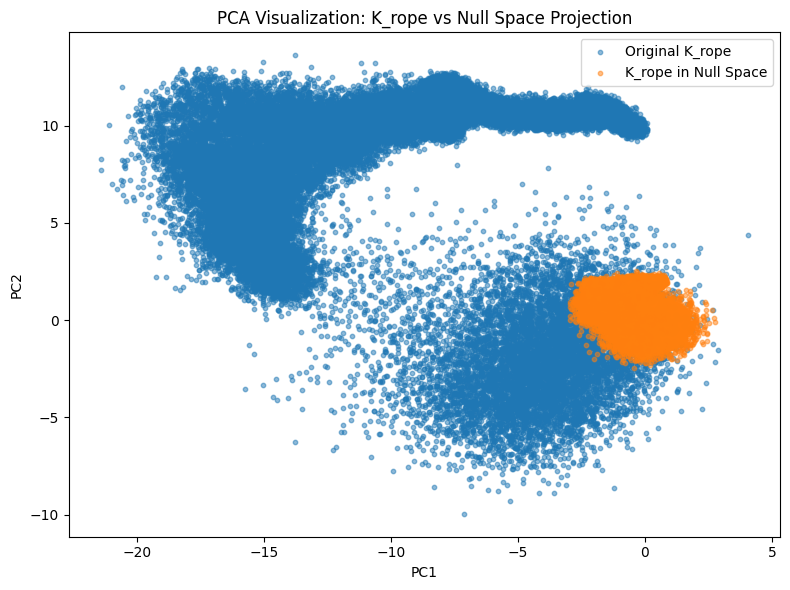

In [26]:
# PCA show
from sklearn.decomposition import PCA
K_null_4k = K_head_64k_before @ null_basis_reserve_64k @ null_basis_reserve_64k.T
# K_combined = torch.cat([K_head_4k_before, K_null_4k], dim=0)
pca = PCA(n_components=2)
pca.fit(K_head_64k_before.cpu().numpy())
V_shared = torch.from_numpy(pca.components_.T).to(K_head_64k_before.device)  # [dim, 2]

K_before_proj = K_head_64k_before @ V_shared
K_null_proj = K_null_4k @ V_shared

plt.figure(figsize=(8, 6))
plt.scatter(K_before_proj[:, 0], K_before_proj[:, 1], label="Original K_rope", alpha=0.5, s=10)
plt.scatter(K_null_proj[:, 0], K_null_proj[:, 1], label="K_rope in Null Space", alpha=0.5, s=10)
plt.title("PCA Visualization: K_rope vs Null Space Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
def cluster_variance(X: torch.Tensor):
    
    mean = X.mean(dim=0, keepdim=True)        # [1, head_dim]
    var = ((X - mean) ** 2).sum(dim=1).mean().sqrt() # scalar

    return var.item()

var_before = cluster_variance(K_head_4k_before)
var_after = cluster_variance(K_head_4k_reserve_rope)
print(var_before)
print(var_after)

17.33112335205078
23.398067474365234


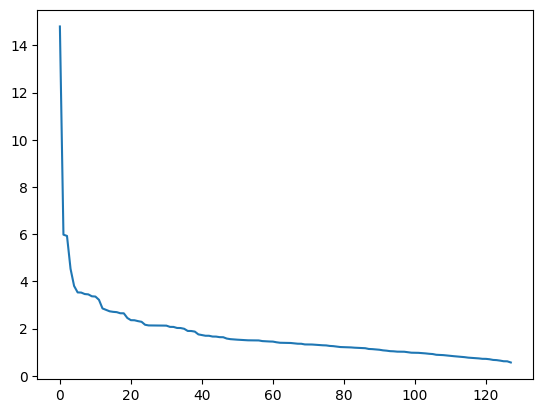

In [5]:
from matplotlib import pyplot as plt
# print((cloud_reserve_rope_4k@cloud_reserve_rope_4k.T).shape)
_, eigs, _ = torch.linalg.svd((K_head_64k_reserve_rope.T@K_head_64k_reserve_rope)/K_head_64k_reserve_rope.shape[0])

plt.figure()
plt.plot(eigs.sqrt().cpu().numpy())
# plt.ylim(-0.1,1.1)
plt.show()

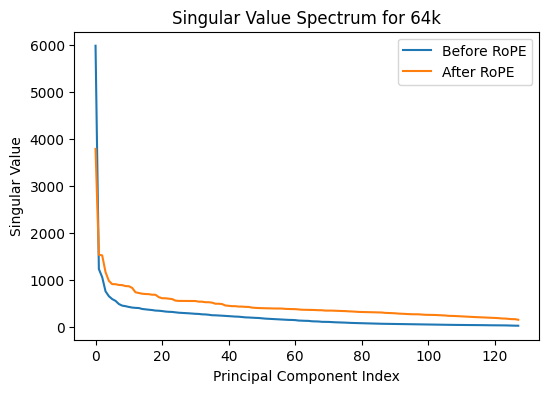

In [9]:
import matplotlib.pyplot as plt

_, S_before, _ = torch.linalg.svd(K_head_64k_before, full_matrices=False)
_, S_after, _ = torch.linalg.svd(K_head_64k_reserve_rope, full_matrices=False)


plt.figure(figsize=(6,4))
plt.plot(S_before.cpu(), label='Before RoPE')
plt.plot(S_after.cpu(), label='After RoPE')
# plt.yscale('log')  
plt.title(f"Singular Value Spectrum for 64k")
plt.xlabel("Principal Component Index")
plt.ylabel("Singular Value")
plt.legend()
# plt.grid(True)
plt.show()

In [3]:
# Project to null space
def apply_null_projection(q_list, k_tensor, null_basis):
    B = null_basis.T
    P = B @ B.T
    q_proj_list = [q @ P for q in q_list]
    k_proj = k_tensor @ P
    return q_proj_list, k_proj

# Q_proj_4k_before_list, K_proj_4k_before = apply_null_projection(Q_4k_before_list, K_head_4k_before, null_basis_4k)
Q_proj_4k_reserve_rope_list, K_proj_4k_reserve_rope = apply_null_projection(Q_4k_rope_list, K_head_4k_rope, null_basis_reserve_4k)
# Q_proj_64k_list, K_proj_64k = apply_null_projection(Q_64k_before_list, K_head_64k_before, null_basis_64k)
Q_proj_64k_reserve_rope_list, K_proj_64k_reserve_rope = apply_null_projection(Q_64k_rope_list, K_head_64k_rope, null_basis_reserve_64k)

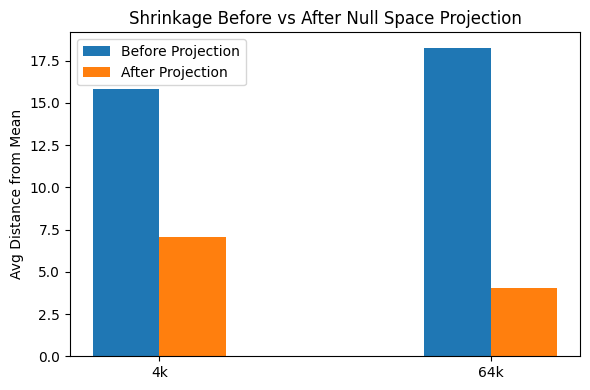

In [ ]:
# plot the average distance
def average_distance_from_mean(x: torch.Tensor) -> float:
    mu = x.mean(dim=0, keepdim=True)
    distances = (x - mu).norm(dim=1)
    return distances.mean().item()

before = [average_distance_from_mean(K_head_4k_rope), average_distance_from_mean(K_head_64k_rope)]
after = [average_distance_from_mean(K_proj_4k_reserve_rope), average_distance_from_mean(K_proj_64k_reserve_rope)]
label = ['4k', '64k']
x = torch.arange(len(label))
bar_width = 0.2

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before, bar_width, label='Before Projection')
plt.bar(x + bar_width/2, after, bar_width, label='After Projection')
plt.ylabel('Avg Distance from Mean')
plt.title('Shrinkage Before vs After Null Space Projection')
plt.xticks(x, label)
plt.legend()
plt.tight_layout()
plt.show()

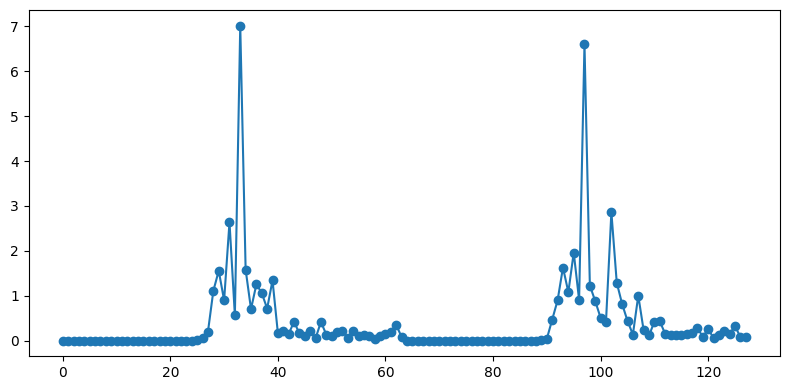

In [ ]:
def null_basis_activation(x, null_basis):
    """
    x: [seq_len, 2*dim] - RoPEed feature
    null_basis: [r, 2*dim]
    return: [seq_len], variance each dim.
    """
    x_proj = x @ (null_basis.T @ null_basis)  # [seq_len, 2*dim]
    return x_proj.var(dim=0)  # [2*dim]


var = null_basis_activation(K_head_4k_rope, null_basis_reserve_4k)  # shape: [2*dim]，例如 [128]

plt.figure(figsize=(8, 4))
plt.plot(range(len(var)), var.cpu().numpy(), marker='o')
plt.grid(False)
plt.tight_layout()
plt.show()

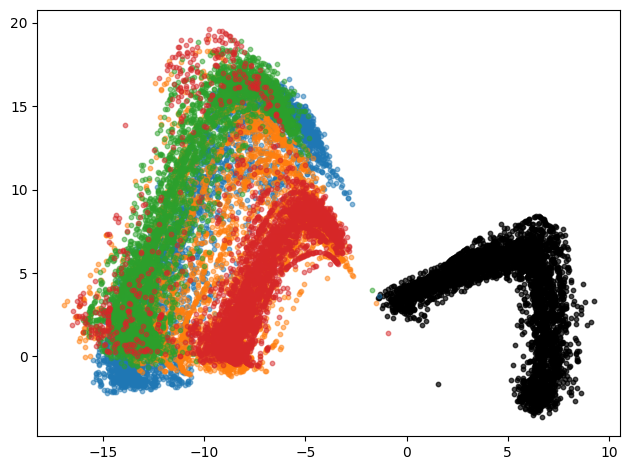

In [6]:
from sklearn.decomposition import PCA

ref_matrix = torch.cat([K_proj_4k_reserve_rope] + Q_proj_4k_reserve_rope_list, dim=0)  # [total_tokens, dim]
pca = PCA(n_components=2)
pca.fit(ref_matrix.cpu().numpy())
V_shared = torch.from_numpy(pca.components_.T).to(ref_matrix.device)  # [dim, 2]

k_proj = K_proj_4k_reserve_rope @ V_shared
plt.scatter(k_proj[:, 0].cpu(), k_proj[:, 1].cpu(), label="K", c='black', s=10, alpha=0.7)

for qi, q in enumerate(Q_proj_4k_reserve_rope_list):
    q_proj = q @ V_shared
    plt.scatter(q_proj[:, 0].cpu(), q_proj[:, 1].cpu(), label=f"Q{qi}", s=10, alpha=0.5)

plt.tight_layout()
plt.show()